In [13]:
import pandas as pd

# Load the data
input_file = "C:\\Users\\ADWIN ADI\\Downloads\\MainData.csv"
output_file = "C:\Users\\ADWIN ADI\\Downloads\\MainData_modified.csv"

df = pd.read_csv(input_file)

# Keep only the first 7 columns
df_filtered = df.iloc[:, :7]

# Save the new file
df_filtered.to_csv(output_file, index=False)

print(f'Filtered CSV saved as {output_file}')


In [18]:
import pandas as pd
import numpy as np
from scipy.signal import detrend

# Load the data
input_file ="C:\\Users\\ADWIN ADI\\Downloads\\MainData_NaN_Removed.csv"
output_file = "C:\\Users\\ADWIN ADI\\Downloads\\Maindata_BW_removed.csv"

df = pd.read_csv(input_file)

# Keep only the first 7 columns
df_filtered = df.iloc[:, :6]

# Remove baseline wandering using detrend
df_filtered = df_filtered.apply(detrend, axis=0)

# Save the new file
df_filtered.to_csv(output_file, index=False)

print(f'Baseline wandering removed CSV saved as {output_file}')


Baseline wandering removed CSV saved as C:\Users\ADWIN ADI\Downloads\Maindata_BW_removed.csv


In [16]:
import pandas as pd



# Load the data
input_file = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData.csv"
output_file = "C:\\Users\\ADWIN ADI\\Downloads\\MainData_nan_removed.csv"
df = pd.read_csv(input_file)
df = df.iloc[:, :7]  # Keep first 7 columns
df = df.dropna()     # Remove rows with missing values
df.to_csv(output_file, index=False)
print(f'Filtered CSV saved as {output_file}')

Filtered CSV saved as C:\Users\ADWIN ADI\Downloads\MainData_nan_removed.csv


Dataset Shape: (109971, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0     -0.241342         -2.692925         16.707508     -0.750359   
1     -0.251330         -2.692917         16.707444     -0.760348   
2     -0.261318         -2.696909         16.887379     -0.770338   
3     -0.261306         -2.700401         17.017314     -0.770327   
4     -0.261293         -2.700393         17.077249     -0.770317   

   Sensor2_Pressure  Sensor2_Humidity Label  
0         -2.021819         14.215375     N  
1         -2.011612         14.215296     N  
2         -1.996005         14.305217     N  
3         -2.006498         14.325137     N  
4         -2.006492         14.325058     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 5s 117ms/step - loss: 0.9374 - accuracy: 0.5751 - val_loss: 0.8417 - val_accuracy: 0.6599
Epoch 2/50
19/19 [==============================] - 2s 85ms/step - loss: 0.8891 - a

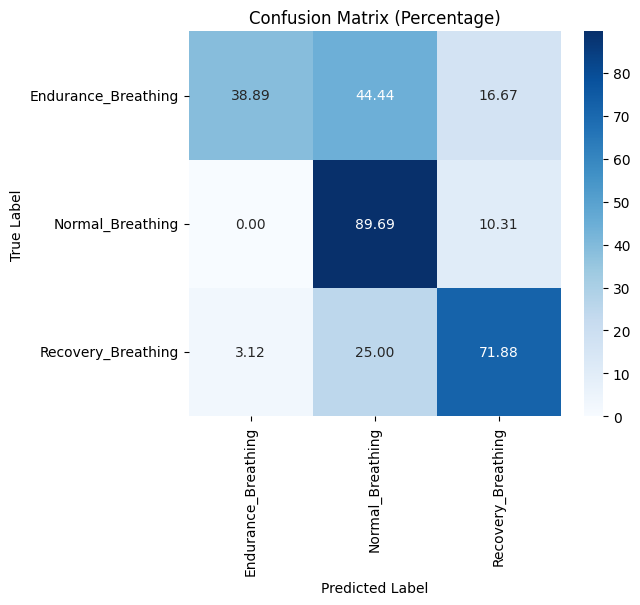

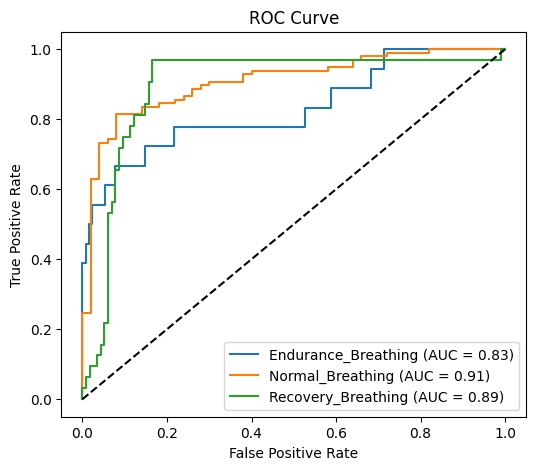

Performance Metrics:
     Metric  Endurance Breathing  Normal Breathing  Recovery Breathing
0      Loss             0.519579          0.519579            0.519579
1  Accuracy             0.795918          0.795918            0.795918
2  F1 Score             0.538462          0.870000            0.676471
Model training completed and saved.


In [9]:
#RNN MODEL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\Maindata_BW_removed.csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build SimpleRNN model
model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)

print("Model training completed and saved.")

Dataset Shape: (109971, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0     -0.241342         -2.692925         16.707508     -0.750359   
1     -0.251330         -2.692917         16.707444     -0.760348   
2     -0.261318         -2.696909         16.887379     -0.770338   
3     -0.261306         -2.700401         17.017314     -0.770327   
4     -0.261293         -2.700393         17.077249     -0.770317   

   Sensor2_Pressure  Sensor2_Humidity Label  
0         -2.021819         14.215375     N  
1         -2.011612         14.215296     N  
2         -1.996005         14.305217     N  
3         -2.006498         14.325137     N  
4         -2.006492         14.325058     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 12s 270ms/step - loss: 0.9977 - accuracy: 0.5461 - val_loss: 0.8922 - val_accuracy: 0.6599
Epoch 2/50
19/19 [==============================] - 3s 185ms/step - loss: 0.8721 -

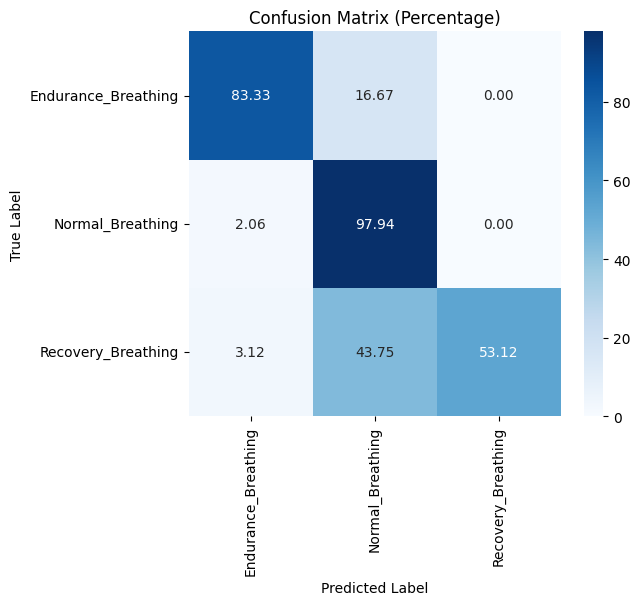

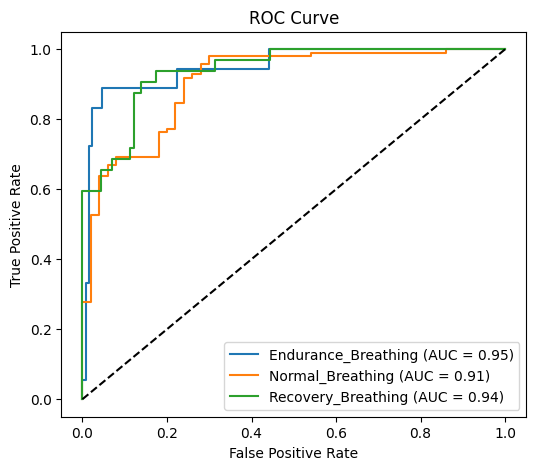

Performance Metrics:
     Metric  Endurance Breathing  Normal Breathing  Recovery Breathing
0      Loss             0.425619          0.425619            0.425619
1  Accuracy             0.863946          0.863946            0.863946
2  F1 Score             0.833333          0.909091            0.693878
Model training completed and saved.


In [8]:
#LSTM MODEL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc,precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\Maindata_BW_removed.csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)

print("Model training completed and saved.")


Dataset Shape: (109971, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0     -0.241342         -2.692925         16.707508     -0.750359   
1     -0.251330         -2.692917         16.707444     -0.760348   
2     -0.261318         -2.696909         16.887379     -0.770338   
3     -0.261306         -2.700401         17.017314     -0.770327   
4     -0.261293         -2.700393         17.077249     -0.770317   

   Sensor2_Pressure  Sensor2_Humidity Label  
0         -2.021819         14.215375     N  
1         -2.011612         14.215296     N  
2         -1.996005         14.305217     N  
3         -2.006498         14.325137     N  
4         -2.006492         14.325058     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 12s 256ms/step - loss: 1.0172 - accuracy: 0.5051 - val_loss: 0.9060 - val_accuracy: 0.6327
Epoch 2/50
19/19 [==============================] - 3s 171ms/step - loss: 0.8786 -

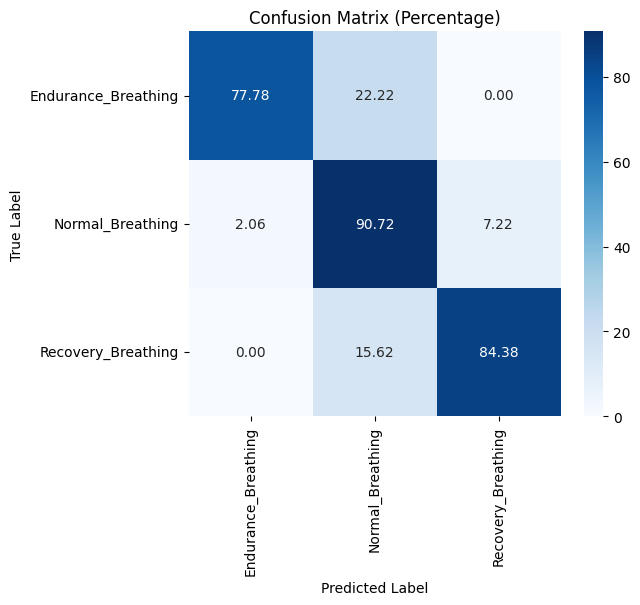

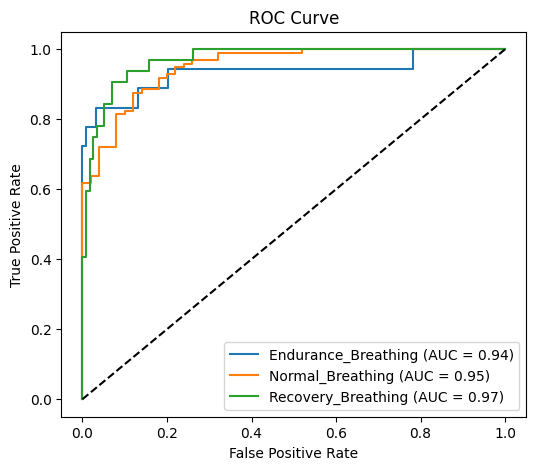

Performance Metrics:
     Metric  Endurance Breathing  Normal Breathing  Recovery Breathing
0      Loss             0.337416          0.337416            0.337416
1  Accuracy             0.877551          0.877551            0.877551
2  F1 Score             0.823529          0.907216            0.818182
Model training completed and saved.


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\Maindata_BW_removed.csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build GRU model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)

print("Model training completed and saved.")


Dataset Shape: (109971, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0     -0.241342         -2.692925         16.707508     -0.750359   
1     -0.251330         -2.692917         16.707444     -0.760348   
2     -0.261318         -2.696909         16.887379     -0.770338   
3     -0.261306         -2.700401         17.017314     -0.770327   
4     -0.261293         -2.700393         17.077249     -0.770317   

   Sensor2_Pressure  Sensor2_Humidity Label  
0         -2.021819         14.215375     N  
1         -2.011612         14.215296     N  
2         -1.996005         14.305217     N  
3         -2.006498         14.325137     N  
4         -2.006492         14.325058     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 25s 477ms/step - loss: 1.0310 - accuracy: 0.5222 - val_loss: 0.9042 - val_accuracy: 0.6599
Epoch 2/50
19/19 [==============================] - 4s 222ms/step - loss: 0.8845 -

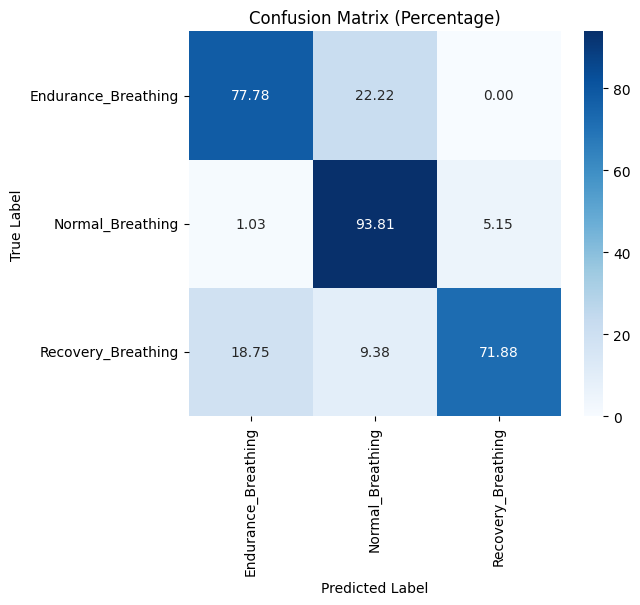

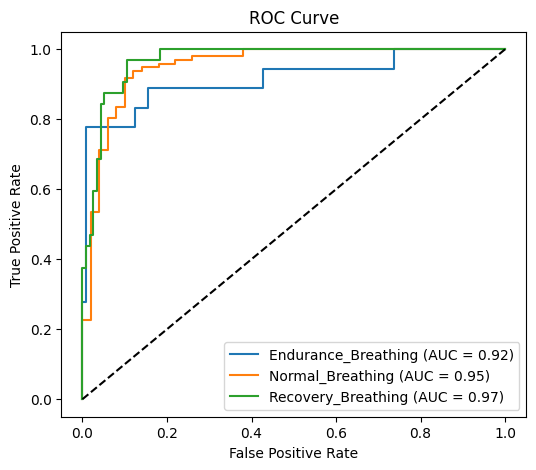

Performance Metrics:
     Metric  Endurance Breathing  Normal Breathing  Recovery Breathing
0      Loss             0.387566          0.387566            0.387566
1  Accuracy             0.870748          0.870748            0.870748
2  F1 Score             0.717949          0.933333            0.766667
Ensemble model training completed and saved.


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, concatenate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\Maindata_BW_removed.csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Define ensemble model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM Branch
lstm_branch = LSTM(64, return_sequences=True)(input_layer)
lstm_branch = Dropout(0.2)(lstm_branch)
lstm_branch = LSTM(32, return_sequences=False)(lstm_branch)
lstm_branch = Dropout(0.2)(lstm_branch)

# GRU Branch
gru_branch = GRU(64, return_sequences=True)(input_layer)
gru_branch = Dropout(0.2)(gru_branch)
gru_branch = GRU(32, return_sequences=False)(gru_branch)
gru_branch = Dropout(0.2)(gru_branch)

# Concatenate branches
merged = concatenate([lstm_branch, gru_branch])
merged = Dense(16, activation='relu')(merged)
out_layer = Dense(y_train.shape[1], activation='softmax')(merged)

# Define and compile model
model = Model(inputs=input_layer, outputs=out_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_ensemble_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Performance Table
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
accuracy = np.mean(y_test_labels == y_pred)
loss = model.evaluate(X_test, y_test, verbose=0)[0]

performance_table = pd.DataFrame({
    "Metric": ["Loss", "Accuracy", "F1 Score"],
    "Endurance Breathing": [loss, accuracy, f1[0]],
    "Normal Breathing": [loss, accuracy, f1[1]],
    "Recovery Breathing": [loss, accuracy, f1[2]]
})

print("Performance Metrics:")
print(performance_table)

print("Ensemble model training completed and saved.")
